In [1]:
from google.colab import drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#from simple_multi_unet_model import multi_unet_model #Uses softmax 

from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt


In [3]:
train_images = []
train_masks = [] 
SIZE_X = 256 
SIZE_Y = 256
n_classes=2
for directory_path in sorted(glob.glob("/content/drive/MyDrive/Colab Notebooks/DATASET_426/")):
    directory_path1 = directory_path + "IMAGES/"
    directory_path2 = directory_path + "MASKS/"
    for img_path in sorted(glob.glob(os.path.join(directory_path1, "*.jpg"))):
        temp1 = img_path.split("/")
        path_val = temp1[len(temp1)-1]
        path_val = path_val[:-4]
        mask_path = directory_path2 + path_val + "_mask.tif"
        #print(img_path)
        img = cv2.imread(img_path,1)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)
        #print(mask_path)
        mask = cv2.imread(mask_path, 0) 
        try:
          mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        except:
          print(mask_path)
          pass      
        train_masks.append(mask)


In [4]:
train_images = np.array(train_images)
train_masks = np.array(train_masks)

print(len(train_images))
print(len(train_masks))

print(train_images.shape)
print(train_masks.shape)

387
387
(387, 256, 256, 3)
(387, 256, 256)


In [5]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1])

In [6]:
#train_images = np.expand_dims(train_images, axis=3)
#train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [ ]:
train_images.shape

(387, 256, 256, 3)

In [7]:
#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

Class values in the dataset are ...  [0 1]


In [8]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))


In [9]:
X_train.shape


(278, 256, 256, 3)

In [10]:
y_train_cat.shape

(278, 256, 256, 2)

In [11]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda


def multi_unet_model(n_classes=2, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model


In [12]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=110, 
                    validation_data=(X_test, y_test_cat), 
                    #class_weight=class_weights,
                    shuffle=False)
model.save('/content/drive/MyDrive/Colab Notebooks/DATASET_426/the_last_hope_500.h5')

In [ ]:
#model.save('test.hdf5')
#model.save('sandstone_50_epochs_catXentropy_acc_with_weights.hdf5')
############################################################
#Evaluate the model
	# evaluate model
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, acc, 'y', label='Training dice_coef')
plt.plot(epochs, val_acc, 'r', label='Validation dice_coef')
plt.title('Training and validation dice_coef')
plt.xlabel('Epochs')
plt.ylabel('Dice_coef')
plt.legend()
plt.show()


In [ ]:
acc = history.history['iou']
val_acc = history.history['val_iou']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
acc = history.history['precision']
val_acc = history.history['val_precision']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, acc, 'y', label='Training precision')
plt.plot(epochs, val_acc, 'r', label='Validation precision')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('precision')
plt.legend()
plt.show()

In [ ]:
acc = history.history['recall']
val_acc = history.history['val_recall']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, acc, 'y', label='Training recall')
plt.plot(epochs, val_acc, 'r', label='Validation recall')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('recall')
plt.legend()
plt.show()

In [14]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/Colab Notebooks/DATASET_426/u_net_500.h5', compile=False)

In [15]:
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

##################################################

#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())



2/2 [==============================] - 7s 1s/step
Mean IoU = 0.824782


(256, 256, 3)
(256, 256, 1)


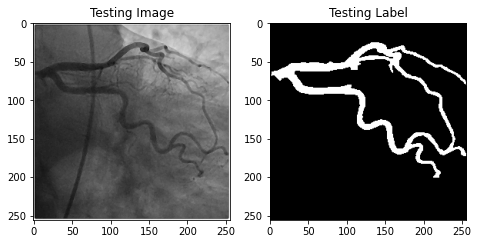

In [16]:
import random
test_img_number = random.randint(0, len(X_test))

test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
print(test_img.shape)
print(ground_truth.shape)


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')

In [17]:
import tensorflow as tf
test_img = tf.expand_dims(test_img, axis=0)
print(test_img.shape)
predict_image =  model.predict(test_img)>0.5
#predict_image =  np.squeeze(predict_image,axis=1)
predict_image = predict_image.astype(np.int32)



(1, 256, 256, 3)
1/1 [==============================] - 0s 205ms/step


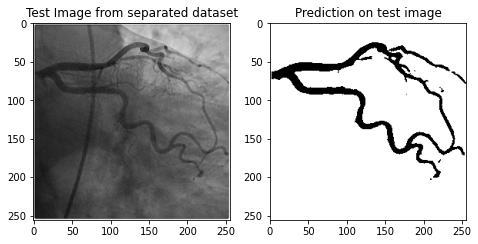

In [19]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Test Image from separated dataset')
plt.imshow(test_img[0,:,:,0], cmap='gray')
#plt.subplot(232)
#plt.title('Testing Label')
#plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Prediction on test image')
plt.imshow(predict_image[0,:,:,0], cmap='gray')
plt.show()

In [ ]:
def sensitivity (seg,ground): 
    #computs false negative rate
    num=np.sum(np.multiply(ground, seg ))
    denom=np.sum(ground)
    if denom==0:
        return 1
    else:
        return  num/denom

def specificity (seg,ground): 
    #computes false positive rate
    num=np.sum(np.multiply(ground==0, seg ==0))
    denom=np.sum(ground==0)
    if denom==0:
        return 1
    else:
        return  num/denom



In [27]:
import tensorflow.keras.metrics

m = tf.keras.metrics.Recall()
m.update_state(y_test, y_pred_argmax)
m.result().numpy()

0.8369626

In [28]:
import tensorflow.keras.metrics

m = tf.keras.metrics.Precision()
m.update_state(y_test, y_pred_argmax)
m.result().numpy()

0.778545

In [36]:
import tensorflow as tf
from tensorflow.keras.metrics import Recall, Precision
import numpy as np
from tensorflow.keras import backend as K

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

In [46]:
import tensorflow.keras.metrics
m = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0])
m.update_state(y_test, y_pred_argmax)
m.result().numpy()

0.97354287